<a href="https://colab.research.google.com/github/roszozhnadzor/tmo/blob/LAB1/%D0%9B%D0%B0%D0%B15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
%matplotlib inline 
sns.set(style="ticks")
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator

In [23]:
# Обучающая выборка
train = pd.read_csv('/content/train.csv')
# Тестовая выборка и подчиненная выборка
test = pd.read_csv('/content/test.csv.xls')
submission = pd.read_csv('/content/submission.csv.xls')

In [24]:
# Удалим дубликаты записей, если они присутствуют
train = train.drop_duplicates()
test = test.drop_duplicates()
submission = submission.drop_duplicates()

In [25]:
# Список колонок с типами данных 
# убедимся что типы данных одинаковы в обучающей и тестовых выборках
train.dtypes

Artist Name            object
Track Name             object
Popularity            float64
danceability          float64
energy                float64
key                   float64
loudness              float64
mode                    int64
speechiness           float64
acousticness          float64
instrumentalness      float64
liveness              float64
valence               float64
tempo                 float64
duration_in min/ms    float64
time_signature          int64
Class                   int64
dtype: object

In [26]:
test.dtypes

Artist Name            object
Track Name             object
Popularity            float64
danceability          float64
energy                float64
key                   float64
loudness              float64
mode                    int64
speechiness           float64
acousticness          float64
instrumentalness      float64
liveness              float64
valence               float64
tempo                 float64
duration_in min/ms    float64
time_signature          int64
dtype: object

In [27]:
submission.dtypes

Acoustic/Folk_0    int64
Alt_Music_1        int64
Blues_2            int64
Bollywood_3        int64
Country_4          int64
HipHop_5           int64
Indie Alt_6        int64
Instrumental_7     int64
Metal_8            int64
Pop_9              int64
Rock_10            int64
dtype: object

In [28]:
# Проверим наличие пустых значений
train.isnull().sum()

Artist Name              0
Track Name               0
Popularity             428
danceability             0
energy                   0
key                   2014
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness      4377
liveness                 0
valence                  0
tempo                    0
duration_in min/ms       0
time_signature           0
Class                    0
dtype: int64

Вывод: в обучающей и тестовых выборках есть пропущенные значения. Избавимся от них:
В стлолбце key соержится несовсем ясная информация, поэтому мы можем удалить его. Также удалим столбец инструментальности трека, так как для анализа достаточно других показателей.

In [29]:
train = train.drop(columns='key') 
train = train.drop(columns='instrumentalness') 
(train.shape, train.shape)
train.isna().sum()

Artist Name             0
Track Name              0
Popularity            428
danceability            0
energy                  0
loudness                0
mode                    0
speechiness             0
acousticness            0
liveness                0
valence                 0
tempo                   0
duration_in min/ms      0
time_signature          0
Class                   0
dtype: int64

In [30]:
def get_columns_with_null_numbers(data):
    num_cols = []
    for col in data.columns:
        # Количество пустых значений
        temp_null_count = data[data[col].isnull()].shape[0]
        total_count = data.shape[0]
        dt = str(data[col].dtype)
        if temp_null_count > 0 and (dt == 'float64' or dt == 'int64'):
            num_cols.append(col)
            temp_perc = round((temp_null_count / total_count) * 100.0, 2)
            print(
                f'''Колонка {col}. Тип данных {dt}. Количество пустых значений {temp_null_count}, {temp_perc}%.''')
    return num_cols

data_num = train[get_columns_with_null_numbers(train)]
data_num.head()

Колонка Popularity. Тип данных float64. Количество пустых значений 428, 2.38%.


,Popularity
0,60.0
1,54.0
2,35.0
3,66.0
4,53.0


Колонка Popularity. Тип данных float64. Количество пустых значений 428, 2.38%.


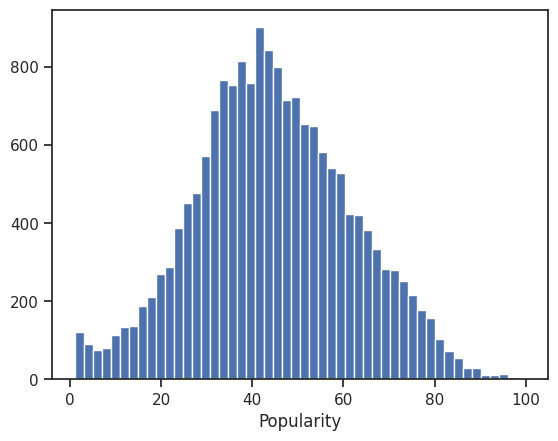

In [31]:
col = get_columns_with_null_numbers(train)
for col in data_num:
    plt.hist(train[col], 50)
    plt.xlabel(col)
    plt.show()


In [32]:
# Так как пустых значений всего 2.38% от выборки, удалим эти строки. 

train = train.dropna(axis=0, how='any')
train.isna().sum()


Artist Name           0
Track Name            0
Popularity            0
danceability          0
energy                0
loudness              0
mode                  0
speechiness           0
acousticness          0
liveness              0
valence               0
tempo                 0
duration_in min/ms    0
time_signature        0
Class                 0
dtype: int64

In [33]:
test = test.dropna(axis=0, how='any')
test.isna().sum()

Artist Name           0
Track Name            0
Popularity            0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
duration_in min/ms    0
time_signature        0
dtype: int64

Болше нулевых значений в выборках нет.

In [34]:
# Разделим выборку 
from sklearn.model_selection import train_test_split
train, test = train_test_split(train, test_size=0.33, random_state=42)

In [35]:
train.shape

(11770, 15)

In [36]:
test.shape

(5798, 15)

In [37]:
scale_cols = ['Popularity', 'danceability', 'energy',
       'loudness', 'mode', 'speechiness', 'acousticness', 'liveness',
       'valence', 'tempo', 'duration_in min/ms', 'time_signature','Class']

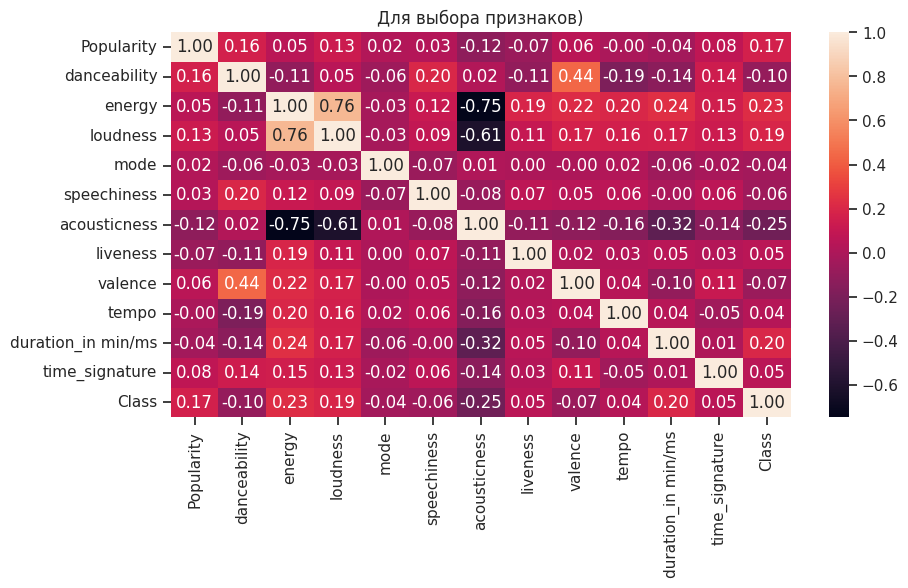

In [38]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(train[scale_cols].corr(), annot=True, fmt='.2f')
ax.set_title('Для выбора признаков)')
plt.show()

In [39]:
from sklearn.ensemble import BaggingClassifier
#сократим выборку для быстроты 
train1 = train.iloc[:1000, :]
bc1 = BaggingClassifier(n_estimators=3, oob_score=True, random_state=10)
bc1.fit(train1[["Popularity", "energy"]], train1["Class"])

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_bagging.py:789: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_bagging.py:795: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]


BaggingClassifier(n_estimators=3, oob_score=True, random_state=10)

In [40]:
# Объекты, использованные в обучающей выборке каждого дерева:
bc1.estimators_samples_

[array([421, 649, 433, 436, 871, 910, 138, 766, 794, 202, 920, 238, 394,
        447, 691, 562, 940, 382, 496, 835, 546, 733, 792, 555, 955, 405,
        754, 486, 740, 748, 954, 762, 826, 368, 755, 630, 360, 814, 104,
        715, 539, 842, 915, 805, 740, 813, 187, 438, 388,  44, 910,  69,
        412, 971, 993, 747, 842, 746, 279, 423, 620, 188, 832, 427,   0,
        767,  50, 713, 406, 590, 939,  42, 112,  77, 668, 306,   4, 626,
        782, 568, 170, 964, 873, 460, 299,  39, 248, 196, 703, 555, 139,
        468, 991, 237, 592, 432, 639, 415, 372, 225,  56,  54, 711, 946,
        210, 622, 394, 237, 220, 648, 461, 772,  79, 830, 812, 572, 730,
        111, 330, 153, 626, 381, 451, 393, 709, 614, 153, 344,  14, 642,
        619, 878, 175, 374, 809, 731, 407, 942, 574, 464, 834,  37,  14,
         52, 632, 885, 224, 171, 465, 324, 688, 683, 472, 725, 329, 190,
        551, 242, 444, 616,  92, 454, 662, 504, 556, 139, 421, 534, 767,
        423, 578, 675, 875, 427, 283, 241, 480, 750

In [41]:

# Построим бинарную матрицу, чтобы наглядно показать данные, попавшие в обучающую выборку. 1 = попадание в выборку
bin_array = np.zeros((3, train1[["Popularity", "energy"]].shape[0]))
for i in range(3):
    for j in bc1.estimators_samples_[i]:
        bin_array[i][j] = 1
bin_array

array([[1., 0., 0., ..., 1., 0., 1.],
       [0., 1., 1., ..., 0., 1., 1.],
       [1., 1., 0., ..., 1., 0., 1.]])

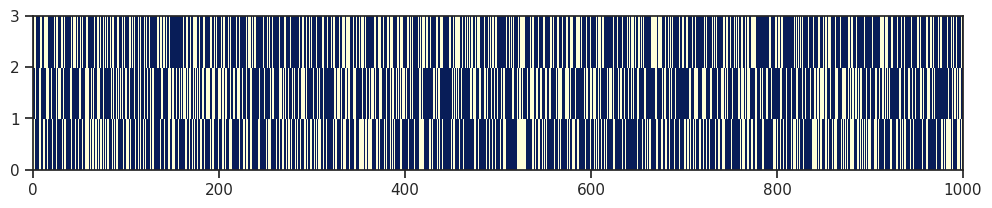

In [42]:
fig, ax = plt.subplots(figsize=(12,2))
ax.pcolor(bin_array, cmap='YlGnBu')
plt.show()

In [43]:
#OUT OF BAG ERROR
for i in range(3):
    cur_data = bin_array[i]
    len_cur_data = len(cur_data)
    sum_cur_data = sum(cur_data)
    (len(bin_array[0]) - sum(bin_array[0])) / len(bin_array[0])
    oob_i = (len_cur_data - sum_cur_data) / len_cur_data
    print('Для модели № {} размер OOB составляет {}%'.format(i+1, round(oob_i, 4)*100.0))

Для модели № 1 размер OOB составляет 35.9%
Для модели № 2 размер OOB составляет 36.8%
Для модели № 3 размер OOB составляет 36.7%


In [44]:
# Out-of-bag error, возвращаемый классификатором
# Для классификации используется метрика accuracy
bc1.oob_score_, 1-bc1.oob_score_

(0.171, 0.829)

In [45]:
# Параметр oob_decision_function_ возвращает вероятности 
# принадлежности объекта к классам на основе oob
# В данном примере три класса, 
# значения nan могут возвращаться в случае маленькой выборки
bc1.oob_decision_function_[55:70]

array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.5       , 0.        , 0.        , 0.5       ,
        0.        ],
       [0.        , 0.66666667, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.33333333],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.66666667,
        0.33333333],
       [0.        , 0.5       , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.5       ],
       [       nan,        nan,        nan,        nan,   

[Text(0.6258612627936359, 0.9791666666666666, 'x[1] <= 0.93\ngini = 0.848\nsamples = 641\nvalue = [34, 66, 64, 29, 24, 79, 112, 36, 122, 140, 294]'),
 Text(0.31669134055608666, 0.9375, 'x[1] <= 0.295\ngini = 0.839\nsamples = 555\nvalue = [34, 62, 60, 27, 24, 79, 105, 36, 30, 136, 267]'),
 Text(0.054648054648054646, 0.8958333333333334, 'x[0] <= 38.5\ngini = 0.812\nsamples = 67\nvalue = [21, 13, 19, 0, 1, 0, 17, 33, 0, 3, 6]'),
 Text(0.019008019008019007, 0.8541666666666666, 'x[0] <= 24.0\ngini = 0.725\nsamples = 25\nvalue = [4, 0, 17, 0, 1, 0, 9, 11, 0, 0, 1]'),
 Text(0.009504009504009503, 0.8125, 'x[0] <= 14.5\ngini = 0.531\nsamples = 5\nvalue = [0, 0, 0, 0, 0, 0, 5, 2, 0, 0, 1]'),
 Text(0.004752004752004752, 0.7708333333333334, 'x[0] <= 9.5\ngini = 0.5\nsamples = 2\nvalue = [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]'),
 Text(0.002376002376002376, 0.7291666666666666, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]'),
 Text(0.007128007128007128, 0.7291666666666666, 'gini = 0.

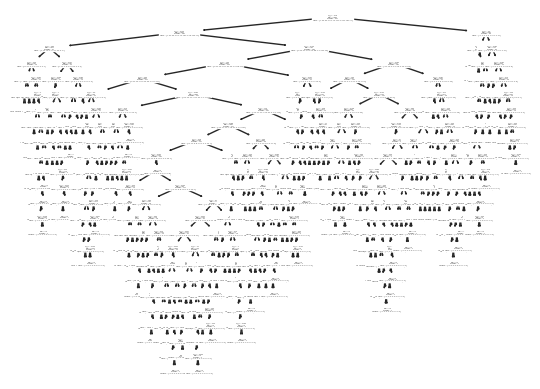

In [46]:
#Визуализация обученных деревьев
from sklearn import tree

tree.plot_tree(bc1.estimators_[0]) 

In [47]:
tree.plot_tree(bc1.estimators_[1]) 

[Text(0.614975941882179, 0.9827586206896551, 'x[1] <= 0.916\ngini = 0.849\nsamples = 632\nvalue = [37, 85, 69, 26, 17, 77, 109, 36, 105, 148, 291]'),
 Text(0.2577857964800558, 0.9482758620689655, 'x[1] <= 0.334\ngini = 0.848\nsamples = 530\nvalue = [37, 74, 66, 25, 17, 74, 95, 36, 31, 148, 237]'),
 Text(0.06902328698274418, 0.9137931034482759, 'x[1] <= 0.191\ngini = 0.831\nsamples = 80\nvalue = [20, 6, 21, 6, 0, 2, 11, 33, 0, 8, 9]'),
 Text(0.036857094990785724, 0.8793103448275862, 'x[0] <= 38.0\ngini = 0.693\nsamples = 33\nvalue = [2, 4, 7, 0, 0, 0, 5, 26, 0, 5, 2]'),
 Text(0.01742335399564416, 0.8448275862068966, 'x[0] <= 34.5\ngini = 0.75\nsamples = 10\nvalue = [1, 0, 5, 0, 0, 0, 2, 3, 0, 5, 0]'),
 Text(0.010722063997319484, 0.8103448275862069, 'x[0] <= 24.0\ngini = 0.7\nsamples = 7\nvalue = [1, 0, 4, 0, 0, 0, 2, 3, 0, 0, 0]'),
 Text(0.005361031998659742, 0.7758620689655172, 'x[1] <= 0.137\ngini = 0.5\nsamples = 3\nvalue = [0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0]'),
 Text(0.002680515999329

Error in callback <function flush_figures at 0x7fd9b37a7a60> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
tree.plot_tree(bc1.estimators_[2]) 

In [48]:
#Визуализация результатов классификации
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #Можно проверить все ли метки классов предсказываются
    #print(np.unique(Z))
    out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_cl(clf):
    title = clf.__repr__
    clf.fit(train1[["Popularity", "energy"]], train1[['Class']])
    fig, ax = plt.subplots(figsize=(5,5))
    X0 = train1["Popularity"]
    X1 = train1["energy"]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=train1['Class'], cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Popularity')
    ax.set_ylabel('energy')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


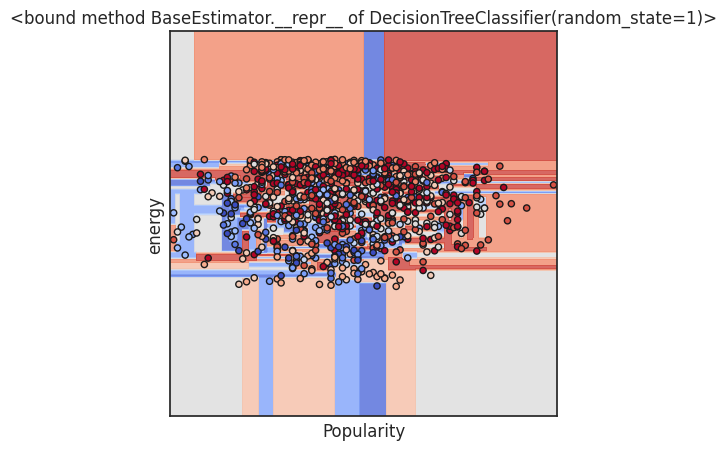

In [49]:
plot_cl(DecisionTreeClassifier(random_state=1))

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(


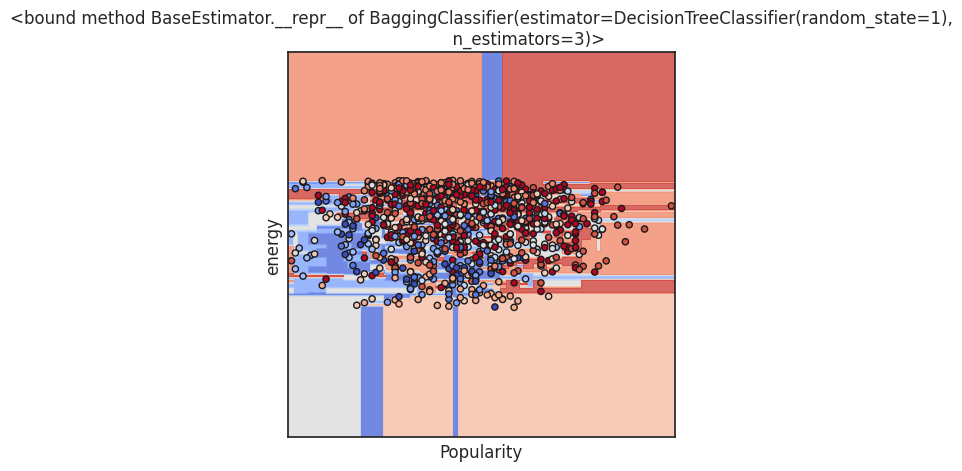

In [50]:
plot_cl(BaggingClassifier(DecisionTreeClassifier(random_state=1), n_estimators=3))

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(


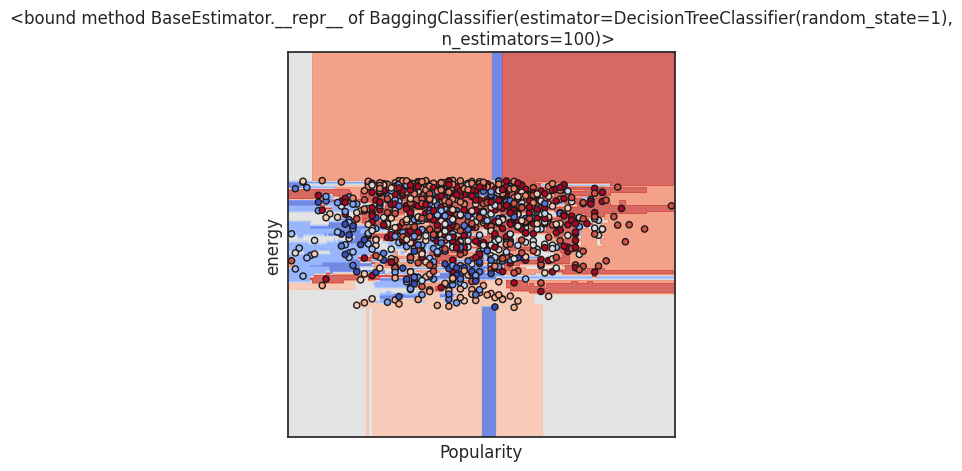

In [51]:
plot_cl(BaggingClassifier(DecisionTreeClassifier(random_state=1), n_estimators=100))

#Бустинг

In [52]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
ab1 = AdaBoostClassifier(n_estimators=3, algorithm='SAMME', random_state=10)
ab1.fit(train1[["Popularity", "energy"]], train1[['Class']])

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier(algorithm='SAMME', n_estimators=3, random_state=10)

[Text(0.5, 0.75, 'x[1] <= 0.921\ngini = 0.853\nsamples = 1000\nvalue = [0.039, 0.068, 0.066, 0.032, 0.025, 0.087, 0.112, 0.034\n0.111, 0.141, 0.285]'),
 Text(0.25, 0.25, 'gini = 0.85\nsamples = 850\nvalue = [0.039, 0.058, 0.063, 0.031, 0.025, 0.085, 0.102, 0.034\n0.031, 0.139, 0.243]'),
 Text(0.75, 0.25, 'gini = 0.627\nsamples = 150\nvalue = [0.0, 0.01, 0.003, 0.001, 0.0, 0.002, 0.01, 0.0, 0.08\n0.002, 0.042]')]

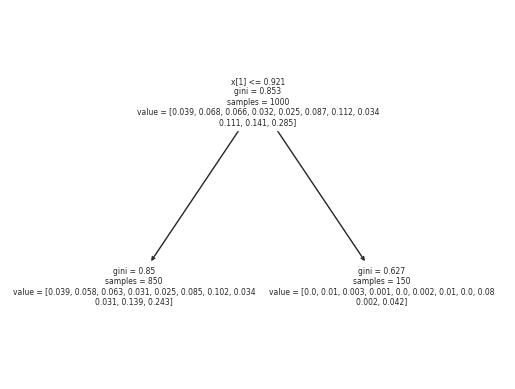

In [53]:
tree.plot_tree(ab1.estimators_[0]) 

[Text(0.5, 0.75, 'x[1] <= 0.918\ngini = 0.884\nsamples = 1000\nvalue = [0.052, 0.091, 0.089, 0.043, 0.034, 0.117, 0.15, 0.046\n0.064, 0.189, 0.125]'),
 Text(0.25, 0.25, 'gini = 0.879\nsamples = 840\nvalue = [0.052, 0.077, 0.085, 0.042, 0.034, 0.113, 0.137, 0.046\n0.04, 0.187, 0.066]'),
 Text(0.75, 0.25, 'gini = 0.706\nsamples = 160\nvalue = [0.0, 0.015, 0.004, 0.001, 0.0, 0.004, 0.013, 0.0\n0.024, 0.003, 0.058]')]

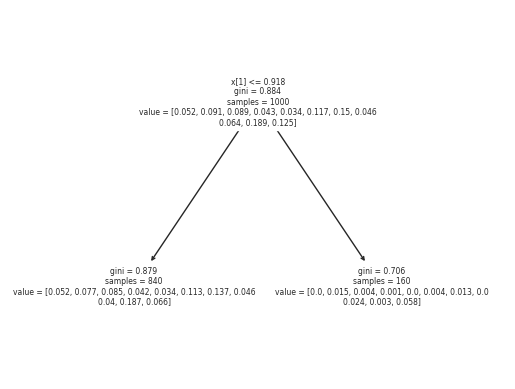

In [54]:
tree.plot_tree(ab1.estimators_[1]) 

[Text(0.5, 0.75, 'x[1] <= 0.334\ngini = 0.891\nsamples = 1000\nvalue = [0.063, 0.11, 0.107, 0.052, 0.04, 0.141, 0.181, 0.055\n0.077, 0.072, 0.102]'),
 Text(0.25, 0.25, 'gini = 0.808\nsamples = 124\nvalue = [0.036, 0.01, 0.026, 0.006, 0.003, 0.002, 0.024, 0.053\n0.0, 0.006, 0.004]'),
 Text(0.75, 0.25, 'gini = 0.877\nsamples = 876\nvalue = [0.027, 0.1, 0.081, 0.045, 0.037, 0.139, 0.157, 0.002\n0.077, 0.067, 0.097]')]

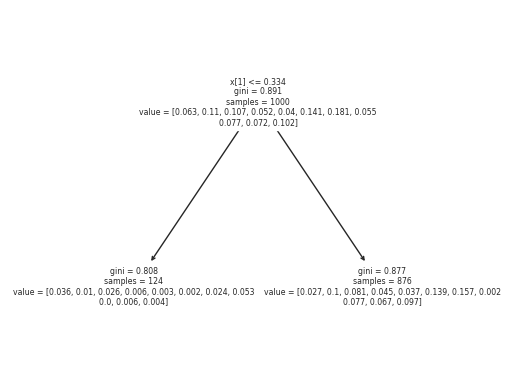

In [55]:
tree.plot_tree(ab1.estimators_[2]) 

#Визуализация классификации

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


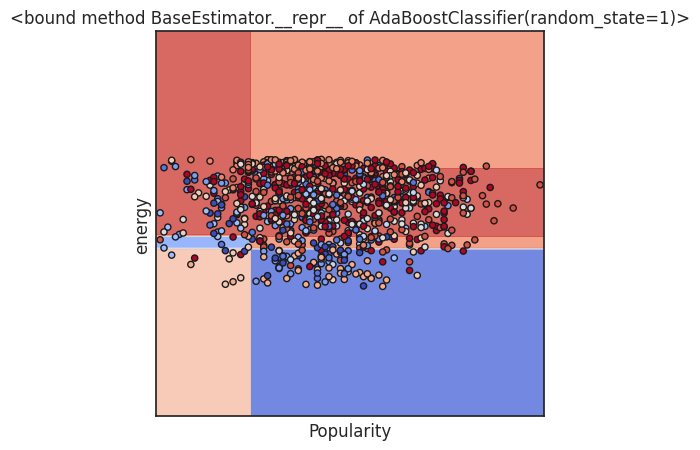

In [56]:
plot_cl(AdaBoostClassifier(random_state=1))

In [57]:
#Визуализация важности признаков
from operator import itemgetter

def draw_feature_importances(tree_model, X_dataset, figsize=(10,5)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

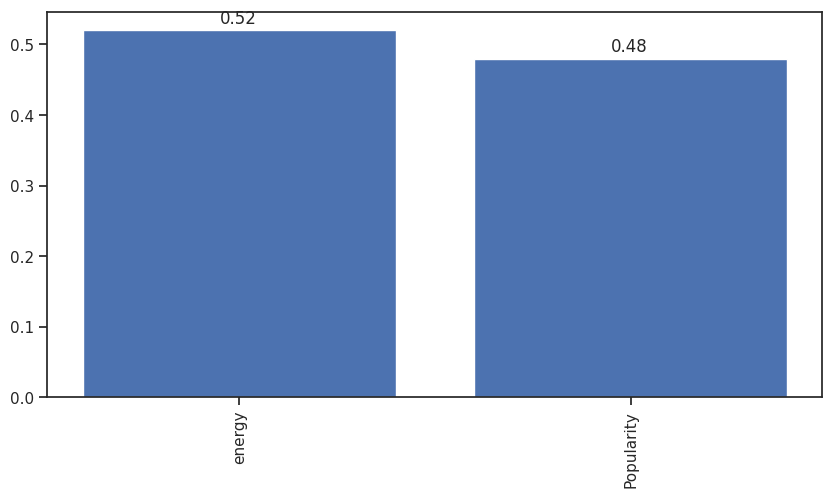

In [58]:
dataset_x_ds = pd.DataFrame(data=train1[["Popularity", "energy"]], columns=['Popularity', 'energy'])
ab2 = AdaBoostClassifier(random_state=1)
ab2.fit(dataset_x_ds, train1["Class"])
_,_ = draw_feature_importances(ab2, dataset_x_ds)

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


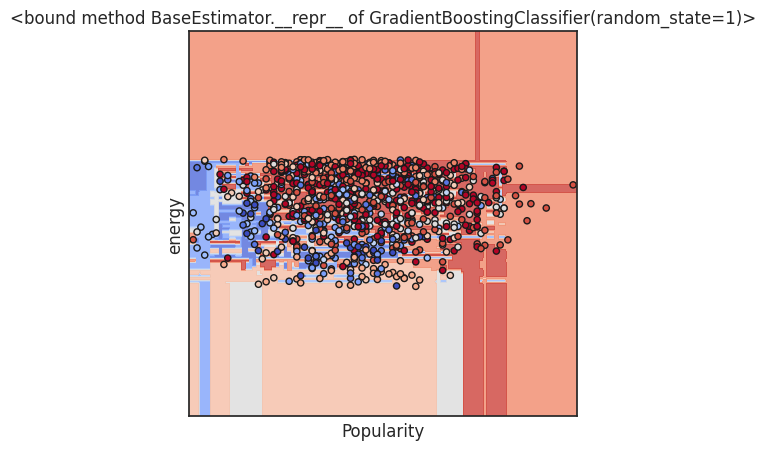

In [59]:
#GradientBoostingClassifier (актуальный алгоритм для бустинга)
plot_cl(GradientBoostingClassifier(random_state=1))

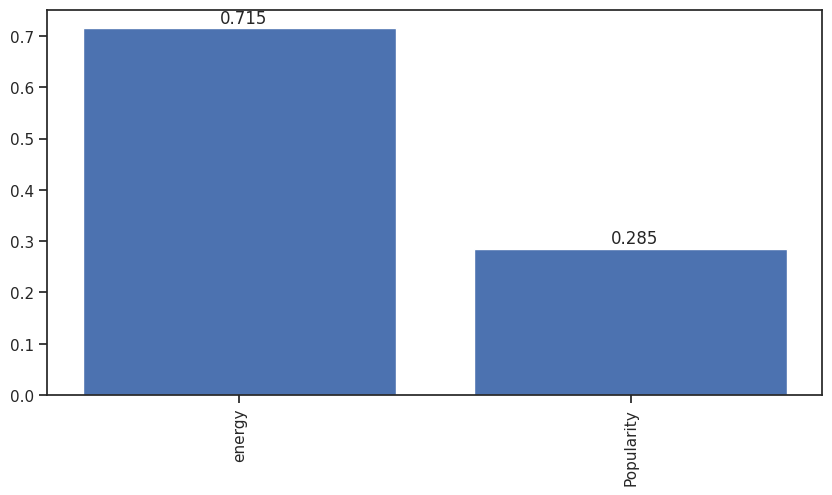

In [61]:
#Важность признаков
dataset_gb_cl = GradientBoostingClassifier(random_state=1)
dataset_gb_cl.fit(dataset_x_ds, train1["Class"])
_,_ = draw_feature_importances(dataset_gb_cl, dataset_x_ds)

In [63]:
#Стекинг
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
estimators = [('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
              ('svr', make_pipeline(StandardScaler(),
              LinearSVC(random_state=42)))]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(train1[["Popularity", "energy"]], train1['Class'])

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(n_estimators=10,
                                                       random_state=42)),
                               ('svr',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('linearsvc',
                                                 LinearSVC(random_state=42))]))],
                   final_estimator=LogisticRegression())

In [64]:
# Средняя точность:
clf.fit(train1[["Popularity", "energy"]], train1['Class']).score(test[["Popularity", "energy"]], test['Class'])


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.31855812349085894

In [65]:
clf.decision_function(train[["Popularity", "energy"]])[55:65]

array([[-0.74100442,  1.18075026,  0.2603295 ,  0.15636257, -0.85287139,
         0.35234641,  1.2233502 , -5.6155784 ,  1.23704615,  0.42099241,
         2.3782767 ],
       [-2.38447272,  1.27708107, -0.77106323, -1.81563848,  0.10206201,
         1.6591866 ,  1.17235662, -6.65806549,  2.16761139,  1.84209087,
         3.40885134],
       [-1.31558054,  0.92639906,  0.2892988 , -0.7113683 , -0.39531521,
         1.1127843 ,  1.23275918, -4.9119605 ,  0.36801008,  1.09699723,
         2.3079759 ],
       [-1.00139723,  0.85963864,  0.09070014, -0.88069604, -0.66720523,
         0.95107245,  1.31835731, -4.97940931, -0.0363573 ,  1.70015226,
         2.64514431],
       [-1.23126638,  0.70033491, -0.08903019, -1.16026427,  0.11346002,
         1.27089755,  1.1463959 , -3.7631401 , -1.07451331,  1.64101507,
         2.4461108 ],
       [-1.64895426,  1.1411576 ,  0.35668784, -0.81131581, -0.66194886,
         1.07088554,  1.30489425, -6.20434977,  1.9652779 ,  0.91469436,
         2.572

In [75]:

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import numpy as np
# Оценим качества моделей метриками:
# Для стекинга 

# создаем прогнозы на тестовом наборе данных
y_pred = clf.predict(train[["Popularity", "energy"]])

# оцениваем качество модели на основе метрик accuracy, precision, recall и f1-score
print(classification_report(train['Class'], y_pred))

              precision    recall  f1-score   support

           0       0.12      0.07      0.09       383
           1       0.00      0.00      0.00       876
           2       0.15      0.08      0.10       860
           3       0.15      0.01      0.02       254
           4       0.00      0.00      0.00       246
           5       0.32      0.01      0.02       940
           6       0.20      0.01      0.02      1699
           7       0.47      0.80      0.59       348
           8       0.45      0.50      0.47      1244
           9       0.27      0.20      0.23      1664
          10       0.31      0.73      0.43      3256

    accuracy                           0.32     11770
   macro avg       0.22      0.22      0.18     11770
weighted avg       0.26      0.32      0.24     11770



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [76]:
# Для бустинга 

# создаем прогнозы на тестовом наборе данных
y_pred = ab1.predict(train[["Popularity", "energy"]])

# оцениваем качество модели на основе метрик accuracy, precision, recall и f1-score
print(classification_report(train['Class'], y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       383
           1       0.00      0.00      0.00       876
           2       0.00      0.00      0.00       860
           3       0.00      0.00      0.00       254
           4       0.00      0.00      0.00       246
           5       0.00      0.00      0.00       940
           6       0.00      0.00      0.00      1699
           7       0.00      0.00      0.00       348
           8       0.41      0.54      0.47      1244
           9       0.00      0.00      0.00      1664
          10       0.26      0.82      0.40      3256

    accuracy                           0.28     11770
   macro avg       0.06      0.12      0.08     11770
weighted avg       0.12      0.28      0.16     11770



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
# Для бэггинга  

# создаем прогнозы на тестовом наборе данных
y_pred = bc1.predict(train[["Popularity", "energy"]])

# оцениваем качество модели на основе метрик accuracy, precision, recall и f1-score
print(classification_report(train['Class'], y_pred))

              precision    recall  f1-score   support

           0       0.12      0.22      0.16       383
           1       0.12      0.14      0.13       876
           2       0.19      0.22      0.20       860
           3       0.13      0.22      0.17       254
           4       0.11      0.14      0.12       246
           5       0.19      0.23      0.20       940
           6       0.20      0.15      0.18      1699
           7       0.46      0.41      0.44       348
           8       0.45      0.40      0.43      1244
           9       0.28      0.23      0.25      1664
          10       0.39      0.36      0.37      3256

    accuracy                           0.27     11770
   macro avg       0.24      0.25      0.24     11770
weighted avg       0.28      0.27      0.27     11770



Вывод: стэкинг самая точная модель. 

In [81]:
# Многослойный персептрон 
from sklearn.neural_network import MLPClassifier

# разделение на признаки и целевую переменную
X = train[["Popularity", "energy"]]
y = train["Class"]

# масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# разбиение на тренировочный и тестовый наборы данных
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# создание модели многослойного персептрона
clf1 = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000, random_state=42)

# обучение модели на тренировочном наборе данных
clf1.fit(X_train, y_train)

# оценка качества модели на тестовом наборе данных
score = clf1.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.33050127442650806


In [85]:
# МГУА
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# разделение на признаки и целевую переменную
X = train1[["Popularity", "energy"]]
y = train1["Class"]

# разбиение на тренировочный и тестовый наборы данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# создание базовых моделей
rf = RandomForestClassifier(n_estimators=10, random_state=42)
mlp = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000, random_state=42)

# создание модели МГУА
estimators = [('rf', rf), ('mlp', mlp)]
clf2 = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# обучение модели на тренировочном наборе данных
clf2.fit(X_train, y_train)

# оценка качества модели на тестовом наборе данных
score = clf2.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.35
